## ML-7. Практика

In [1]:
#импорт библиотек

import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna

plt.style.use('seaborn')

### Описание задачи

**Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).**

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Нужно обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

### Загрузка и исследование данных

In [2]:
data = pd.read_csv('data/train_sem09.csv')
data

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


Проверяем наличие пропусков

In [3]:
data.isnull().sum().value_counts()

0    1777
dtype: int64

Смотрим, что все признаки числовые

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


Смотрим на сбалансированность классов:

<AxesSubplot:xlabel='Activity', ylabel='count'>

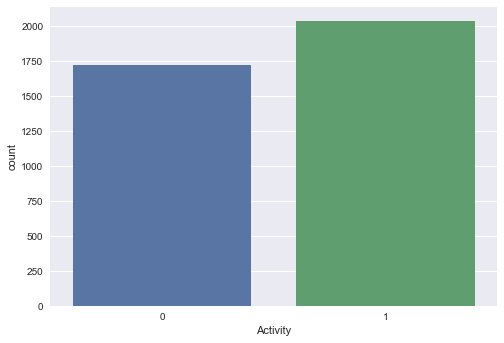

In [5]:
sns.countplot(data=data, x='Activity')

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [6]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

### **Логистическая регрессия**

Зафиксируем метрики, полученные без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [8]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter=1000, random_state=42)

#Обучаем модель, минимизируя logloss и выводим значения метрики на тестовой выборке
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.777


#### **Оптимизация гиперпараметров модели**

### GridSearchCV

In [9]:
#зададим сетку гиперпараметров в виде списка словарей
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
              'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
              'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]}
             ]

#создадим объект класса GridSearch
grid_search = GridSearchCV(estimator=linear_model.LogisticRegression(random_state=42, #генератор случайных чисел
                                                                     max_iter=1000 #количество итераций на сходимость
                                                                    ), 
                           param_grid=param_grid, 
                           cv=5, #количество фолдов кросс-валидации
                           n_jobs=-1
                          )  

%time grid_search.fit(X_train, y_train) 

y_test_pred = grid_search.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

Wall time: 10min 28s
f1_score на тестовом наборе: 0.778
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}


Метрику удалось улучшить незначительно по сравнению с параметрами, заданными по-умолчанию.

### RandomizedSearchCV

В отличие от GridSearchCV, не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений. Количество комбинаций гиперпараметров задается n_iter.

In [10]:
#зададим сетку гиперпараметров в виде списка словарей
param_distributions = [
                       {'penalty': ['l2', 'none'] , # тип регуляризации
                        'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
                        'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
                        
                       {'penalty': ['l1', 'l2'] ,
                        'solver': ['liblinear', 'saga'],
                        'C': list(np.linspace(0.01, 1, 10, dtype=float))}
                      ]

#создадим объект класса RandomizedSearch          
random_search = RandomizedSearchCV(estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
                                   param_distributions=param_distributions, 
                                   cv=5, #количество фолдов кросс-валидации
                                   n_iter=20, #количество итераций
                                   n_jobs=-1
                                   )  

%time random_search.fit(X_train, y_train) 

y_test_pred = random_search.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')
print(f'Наилучшие значения гиперпараметров: {random_search.best_params_}')

Wall time: 3min 20s
f1_score на тестовом наборе: 0.781
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.23}


Метрику удалось ещё незначительно улучшить по сравнению с GridSearch, при этом методы предложили разные алгоритмы оптимизации.

### Hyperopt

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [11]:
# зафксируем random_state
random_state = 42

def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': params['C']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, 
                                            random_state=random_state, 
                                            max_iter=1000
                                           )

    # обучаем модель
    model.fit(X, y)
    
    # применим  cross validation с количеством фолдов по-умолчанию
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [12]:
# зададим пространство поиска гиперпараметров
space = {'penalty': hp.choice('penalty', ['l1', 'l2']),
         'solver': hp.choice('solver', ['liblinear', 'saga']),
         'C': hp.uniform('C', 0.01, 1)
        }

In [13]:
%%time

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_rf, # наша функция 
            space=space, # пространство гиперпараметров
            algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
            max_evals=20, # максимальное количество итераций
            trials=trials, # логирование результатов
            rstate=np.random.RandomState(random_state) # фиксируем для повторяемости результата
           )

print(f'Наилучшие значения гиперпараметров {best}')

 25%|██▌       | 5/20 [02:04<07:34, 30.27s/trial, best loss: -0.790810832113084] 

d:\Phyton\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 10/20 [04:01<02:17, 13.74s/trial, best loss: -0.790810832113084]

d:\Phyton\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 18/20 [07:01<00:24, 12.13s/trial, best loss: -0.790810832113084]

d:\Phyton\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [09:02<00:00, 27.14s/trial, best loss: -0.790810832113084]
Наилучшие значения гиперпараметров {'C': 0.18015284578259508, 'penalty': 0, 'solver': 1}
Wall time: 9min 2s


In [14]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(random_state=random_state, 
                                        penalty='l1',
                                        solver='saga',
                                        C=best['C'],
                                        max_iter=1000
                                       )

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.777


На тестовой выборке предложенные значения гиперпараметров показали тот же результат, что и значения по умолчанию.

### Optuna

Optuna - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры.

In [15]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial.suggest_float('C', 0.01, 1)

    # создаем модель
    model = linear_model.LogisticRegression(penalty=penalty, 
                                            solver=solver,
                                            C=C,
                                            max_iter=1000,
                                            random_state=42)
    # обучаем модель
    model.fit(X_train, y_train)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

    return score

In [16]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name='LogisticRegression', direction='maximize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-08-17 22:25:31,489] A new study created in memory with name: LogisticRegression
[I 2022-08-17 22:26:26,726] Trial 0 finished with value: 0.7771744045455328 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.7574851790731563}. Best is trial 0 with value: 0.7771744045455328.
[I 2022-08-17 22:26:27,486] Trial 1 finished with value: 0.7639795935671146 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.04046280535583394}. Best is trial 0 with value: 0.7771744045455328.
d:\Phyton\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2022-08-17 22:28:45,713] Trial 2 finished with value: 0.7789715711027455 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.8902846674197188}. Best is trial 2 with value: 0.7789715711027455.
[I 2022-08-17 22:29:37,498] Trial 3 finished with value: 0.7784559743417836 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.69

Wall time: 8min 19s


In [17]:
# выводим результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value :.3f}')

Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.23192086284262386}
f1_score на обучающем наборе: 0.788


In [18]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.780


In [19]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Optuna предложила значения параметров, которые дали результат, близкий к результату, полученному от параметров, заданных по-умолчанию.

### **Случайный лес**

Зафиксируем метрики, полученные без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [20]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)

#Выводим значения метрики а1
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.805


Случайный лес сразу выдает результаты, лучше, чем у логистической регресии

#### **Оптимизация гиперпараметров модели**

### GridSearchCV

In [21]:
param_grid = {'n_estimators': list(range(80, 200, 20)),
              'min_samples_leaf': list(range(1, 10, 1)),
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
             }
            
grid_search_forest = GridSearchCV(estimator=ensemble.RandomForestClassifier(random_state=42), 
                                  param_grid=param_grid, 
                                  cv=5, 
                                  n_jobs=-1
                                 )  

%time grid_search_forest.fit(X_train, y_train) 

y_test_pred = grid_search_forest.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_forest.best_params_}')

Wall time: 5min 41s
f1_score на тестовом наборе: 0.804
Наилучшие значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 180}


### RandomizedSearchCV

In [22]:
param_distributions = {'n_estimators': list(range(80, 200, 20)),
                       'min_samples_leaf': list(range(1, 10, 1)),
                       'max_depth': list(np.linspace(20, 40, 5, dtype=int))
                      }
            
random_search_forest = RandomizedSearchCV(estimator=ensemble.RandomForestClassifier(random_state=42), 
                                          param_distributions=param_distributions, 
                                          cv=5,
                                          n_iter=30, 
                                          n_jobs=-1
                                         )  

%time random_search_forest.fit(X_train, y_train) 

y_test_pred = random_search_forest.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_forest.best_params_}')

Wall time: 41.8 s
f1_score на тестовом наборе: 0.806
Наилучшие значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 180}


RandomizedSearch показал себя снова лучше по подбору параметров, чем GridSearch, плюс удалось улучшить значение метрики.

### Hyperopt

In [23]:
# зафксируем random_state
random_state = 42

def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'min_samples_leaf': int(params['min_samples_leaf'])
             }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
   
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [24]:
# зададим пространство поиска гиперпараметров
space = {'n_estimators': hp.quniform('n_estimators', 80, 200, 1),
         'max_depth' : hp.quniform('max_depth', 10, 40, 1),
         'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
        }

In [25]:
%%time

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_rf, # наша функция 
            space=space, # пространство гиперпараметров
            algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
            max_evals=30, # максимальное количество итераций
            trials=trials, # логирование результатов
            rstate=np.random.RandomState(random_state) # фиксируем для повторяемости результата
           )

print(f'Наилучшие значения гиперпараметров {best}')

100%|██████████| 30/30 [01:36<00:00,  3.21s/trial, best loss: -0.8161716791886346]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 2.0, 'n_estimators': 117.0}
Wall time: 1min 36s


In [26]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(random_state=random_state, 
                                        n_estimators=int(best['n_estimators']),
                                        max_depth=int(best['max_depth']),
                                        min_samples_leaf=int(best['min_samples_leaf'])
                                       )

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.799


### Optuna

In [27]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 80, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 40, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=random_state)
    # обучаем модель
    model.fit(X_train, y_train)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

    return score

In [28]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

[I 2022-08-17 22:41:54,699] A new study created in memory with name: RandomForestClassifier
[I 2022-08-17 22:41:58,986] Trial 0 finished with value: 0.807453603778122 and parameters: {'n_estimators': 194, 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.807453603778122.
[I 2022-08-17 22:42:02,014] Trial 1 finished with value: 0.8093288739819073 and parameters: {'n_estimators': 105, 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8093288739819073.
[I 2022-08-17 22:42:04,890] Trial 2 finished with value: 0.808930076303081 and parameters: {'n_estimators': 102, 'max_depth': 37, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8093288739819073.
[I 2022-08-17 22:42:07,726] Trial 3 finished with value: 0.7966328165173924 and parameters: {'n_estimators': 123, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8093288739819073.
[I 2022-08-17 22:42:09,832] Trial 4 finished with value: 0.7955326583191786 and parameters: {'n_est

Wall time: 1min 44s


In [29]:
# выводим результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value :.3f}')

Наилучшие значения гиперпараметров {'n_estimators': 114, 'max_depth': 33, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.816


In [30]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.800


##### **Вывод:** Выбор правильной модели машинного обучения важнее подбора гиперпараметров. При поиске гиперпараметров на предложенных данных лучше всего себя показал RandomizedSearch, хоть и не значительно, но метрика f1 была улучшена. Optuna и Hyperopt показали хороший результат на тренировочный выборке, но применение параметров на тестововой выборке на дало улучшения. Возможно причина в заданном диапазоне параметров.